In [1]:
%load_ext autoreload
%autoreload 2
import os, argparse, random, math, sys, pickle, scipy
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import bootstrap
# plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Serif",  # Use a serif font
})
sys.path.append("..")
from data.amr_uti import generate_amr_uti_nc

In [2]:
def get_full_eval_df(num_reps, checkpoint_dir, model): 
    eval_df = []
    for rep in range(num_reps):
        curr_cp_dir = os.path.join(checkpoint_dir, f"rep={rep}", model)
        curr_eval_path = os.path.join(curr_cp_dir, f"eval.csv")
        if os.path.isfile(curr_eval_path):
            curr_eval_df = pd.read_csv(curr_eval_path)
            curr_eval_df["rep"] = rep
            eval_df.append(curr_eval_df)
    eval_df = pd.concat(eval_df)
    return eval_df    
map_dict = {
    "sbd-slearner": "SBD (S-learner)", "sbd-tlearner": "SBD (T-learner)", "sbd-tarnet": "SBD (TarNet)", "sbd-dragon": "SBD (DragonNet)", 
    "cfd-slearner": "CFD (S-learner)", "cfd-tlearner": "CFD (T-learner)", "cfd-tarnet": "CFD (TARNet)", "cfd-dragon": "CFD (DragonNet)", 
    "lobster": "CFD (LobsterNet)"}

In [4]:
num_reps=20
nc_types = ["one-sided", "two-sided"]
model_strs = ["sbd-tlearner", "sbd-dragon", "cfd-tlearner", "lobster"]
nc_rates = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95]

In [5]:
# data_dir = os.path.join("../../data", "AMR-UTI")
# assert os.path.isdir(data_dir)
# delta_A_df = {"nc_type": [], "nc_rate": [], "rep": [], "delta_A": []}
# for nc_type in nc_types:
#     if nc_type == "one-sided":
#         prescriptions = ["NIT"]
#     else:
#         prescriptions = ["NIT", "CIP"]
#     for nc_rate in tqdm(nc_rates): 
#         for rep in tqdm(range(5), leave=False):
#             train_df, test_df, X_cols = generate_amr_uti_nc(
#                 data_dir, rep=rep, prescriptions=prescriptions, 
#                 nc_type=nc_type, nc_rate=nc_rate)
#             delta_A = np.abs(np.mean(test_df["A_T1"] - test_df["A_T0"]))
#             delta_A_df["nc_type"].append(nc_type)
#             delta_A_df["nc_rate"].append(nc_rate)
#             delta_A_df["rep"].append(rep)
#             delta_A_df["delta_A"].append(delta_A)
# delta_A_df = pd.DataFrame(delta_A_df)
# delta_A_df = delta_A_df.drop(columns=["rep"]).groupby(["nc_type", "nc_rate"]).mean().reset_index()

In [6]:
# load one-sided AMR-UTI eval results
nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nc_type="one-sided"
eval_df_list = []
for nc_rate in tqdm(nc_rates): 
    for prescriptions in [["NIT"]]:
        ihdp_setting = f"type={nc_type}/rate={nc_rate}/prescriptions={prescriptions}"
        for model in model_strs:
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"AMR-UTI/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir), ihdp_mod_checkpoint_dir
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["setting"] = ihdp_setting
            ihdp_mod_eval_df["model"] = model
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["prescription"] = prescriptions[0]
            eval_df_list.append(ihdp_mod_eval_df)
one_sided_amruti_eval_df = pd.concat(eval_df_list)
one_sided_amruti_eval_df.model = one_sided_amruti_eval_df.model.map(map_dict)
one_sided_amruti_eval_df = one_sided_amruti_eval_df.drop(columns=["delta_A"]).merge(
    one_sided_amruti_eval_df.groupby(["rep", "setting", "nc_rate"])["delta_A"].mean().reset_index(), 
    on=["rep", "setting", "nc_rate"])
# one_sided_amruti_eval_df = one_sided_amruti_eval_df.merge(delta_A_df[delta_A_df.nc_type=="one-sided"][["nc_rate", "delta_A"]], on="nc_rate")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


In [7]:
# load two-sided AMR-UTI eval results
num_reps=20
nc_type="two-sided"
model_strs = ["sbd-tlearner", "sbd-dragon", "cfd-tlearner", "cfd-tarnet", "cfd-dragon", "lobster"]
nc_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.25, 0.65]
eval_df_list = []
for nc_rate in tqdm(nc_rates): 
    for idx, prescriptions in enumerate([["NIT", "CIP"]]):
        ihdp_setting = f"type={nc_type}/rate={nc_rate}/prescriptions={prescriptions}"
        for model in model_strs:
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"AMR-UTI/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir)
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["setting"] = ihdp_setting
            ihdp_mod_eval_df["model"] = model
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["type"] = idx
            eval_df_list.append(ihdp_mod_eval_df)
two_sided_amruti_eval_df = pd.concat(eval_df_list)
two_sided_amruti_eval_df.model = two_sided_amruti_eval_df.model.map(map_dict)
two_sided_amruti_eval_df = two_sided_amruti_eval_df.drop(columns=["delta_A"]).merge(
    two_sided_amruti_eval_df.groupby(["rep", "setting", "nc_rate"])["delta_A"].mean().reset_index(), 
    on=["rep", "setting", "nc_rate"])
# two_sided_amruti_eval_df = two_sided_amruti_eval_df.merge(delta_A_df[delta_A_df.nc_type=="two-sided"][["nc_rate", "delta_A"]], on="nc_rate")

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:13<00:00,  1.07s/it]


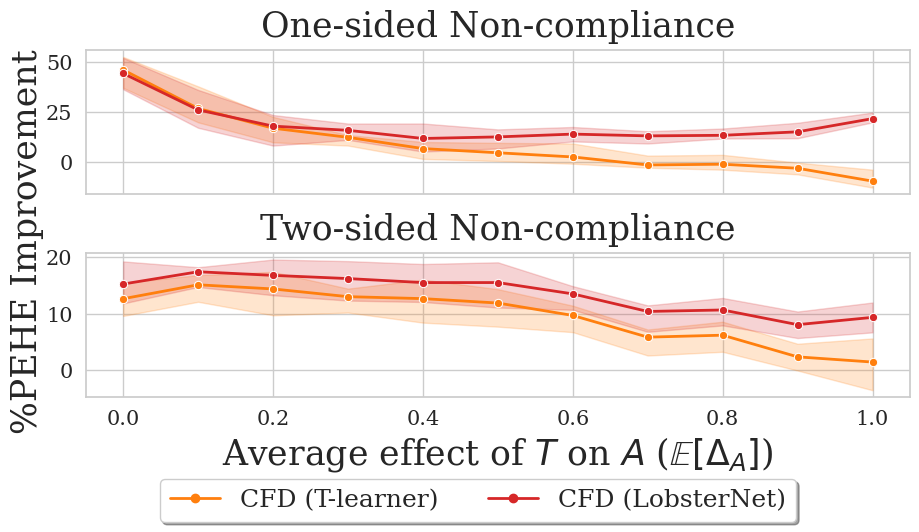

In [8]:
# computing percentage PEHE improvement under one-sided non-compliance
plot_one_sided_amruti_eval_df = one_sided_amruti_eval_df[one_sided_amruti_eval_df.model.isin(["SBD (T-learner)", "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_one_sided_amruti_eval_df["delta_A"] = plot_one_sided_amruti_eval_df.delta_A.round(decimals=1)
sbd_tlearner_one_sided_df = plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.model == "SBD (T-learner)") & (plot_one_sided_amruti_eval_df.label=="assign effect PEHE")].copy()
cfd_tlearner_one_sided_df = plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.model == "CFD (T-learner)") & (plot_one_sided_amruti_eval_df.label=="assign effect PEHE")].copy()
cfd_lobster_one_sided_df = plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.model == "CFD (LobsterNet)") & (plot_one_sided_amruti_eval_df.label=="assign effect PEHE")].copy()
assert len(sbd_tlearner_one_sided_df) == len(cfd_tlearner_one_sided_df) == len(cfd_lobster_one_sided_df)
cfd_tlearner_one_sided_df = cfd_tlearner_one_sided_df.merge(sbd_tlearner_one_sided_df[["nc_rate", "rep", "value"]].rename(columns={"value": "baseline"}), on=["rep", "nc_rate"])
cfd_tlearner_one_sided_df["improvement"] = 100*(cfd_tlearner_one_sided_df["baseline"] - cfd_tlearner_one_sided_df["value"])/cfd_tlearner_one_sided_df["baseline"]
cfd_lobster_one_sided_df = cfd_lobster_one_sided_df.merge(sbd_tlearner_one_sided_df[["nc_rate", "rep", "value"]].rename(columns={"value": "baseline"}), on=["rep", "nc_rate"])
cfd_lobster_one_sided_df["improvement"] = 100*(cfd_lobster_one_sided_df["baseline"] - cfd_lobster_one_sided_df["value"])/cfd_lobster_one_sided_df["baseline"]

# computing percentage PEHE improvement under two-sided non-compliance
plot_two_sided_amruti_eval_df = two_sided_amruti_eval_df[two_sided_amruti_eval_df.model.isin(["SBD (T-learner)", "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_two_sided_amruti_eval_df["delta_A"] = plot_two_sided_amruti_eval_df.delta_A.round(decimals=1)
sbd_tlearner_two_sided_df = plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.model == "SBD (T-learner)") & (plot_two_sided_amruti_eval_df.label=="assign effect PEHE")].copy()
cfd_tlearner_two_sided_df = plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.model == "CFD (T-learner)") & (plot_two_sided_amruti_eval_df.label=="assign effect PEHE")].copy()
cfd_lobster_two_sided_df = plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.model == "CFD (LobsterNet)") & (plot_two_sided_amruti_eval_df.label=="assign effect PEHE")].copy()
assert len(sbd_tlearner_two_sided_df) >= len(cfd_tlearner_two_sided_df)
assert len(sbd_tlearner_two_sided_df) >=  len(cfd_lobster_two_sided_df)
cfd_tlearner_two_sided_df = cfd_tlearner_two_sided_df.merge(sbd_tlearner_two_sided_df[["nc_rate", "rep", "value"]].rename(columns={"value": "baseline"}), on=["rep", "nc_rate"], how="left")
cfd_tlearner_two_sided_df["improvement"] = 100*(cfd_tlearner_two_sided_df["baseline"] - cfd_tlearner_two_sided_df["value"])/cfd_tlearner_two_sided_df["baseline"]
cfd_lobster_two_sided_df = cfd_lobster_two_sided_df.merge(sbd_tlearner_two_sided_df[["nc_rate", "rep", "value"]].rename(columns={"value": "baseline"}), on=["rep", "nc_rate"], how="left")
cfd_lobster_two_sided_df["improvement"] = 100*(cfd_lobster_two_sided_df["baseline"] - cfd_lobster_two_sided_df["value"])/cfd_lobster_two_sided_df["baseline"]


sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
palette = sns.color_palette(['tab:orange', 'tab:red'])
fig, axes = plt.subplots(2, 1, figsize=(10*0.9, 5), sharex="col")
sns.lineplot(data=pd.concat((cfd_tlearner_one_sided_df, cfd_lobster_one_sided_df)), 
             x="delta_A", y="improvement", hue="model", style="model", ax=axes[0], markers=["o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
sns.lineplot(data=pd.concat((cfd_tlearner_two_sided_df, cfd_lobster_two_sided_df)), 
             x="delta_A", y="improvement", hue="model", style="model", ax=axes[1], markers=["o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
fig.text(-0.02, 0.5, "%PEHE Improvement", va='center', rotation='vertical', fontsize=25)
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Average effect of $T$ on $A$ ($\mathbb{E}[\Delta_A]$)", fontsize=25)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=18,
           fancybox=True, shadow=True)
fig.tight_layout()
fig.savefig("outputs/amruti_improve.pdf", bbox_inches='tight')

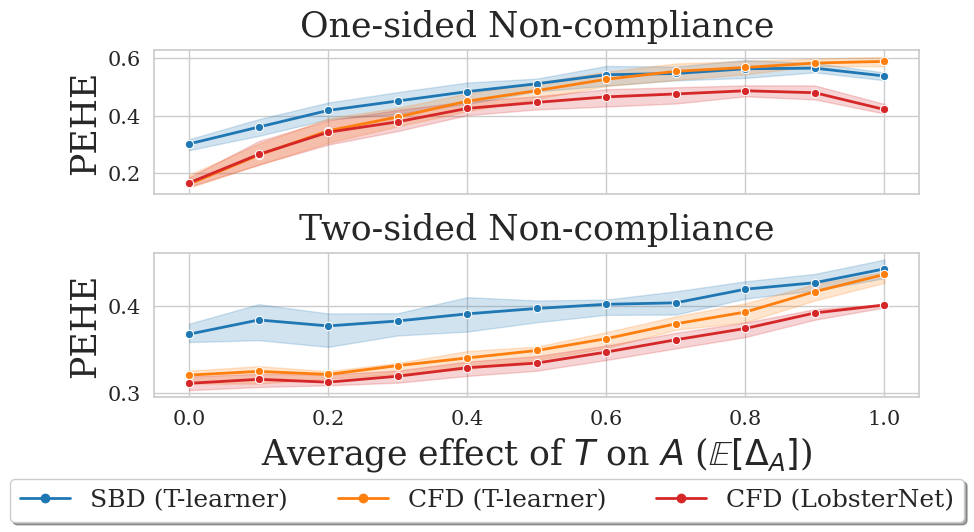

In [ ]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
palette = sns.color_palette(['tab:blue', 'tab:orange', 'tab:red'])
fig, axes = plt.subplots(2, 1, figsize=(10*0.9, 5), sharex="col")
plot_one_sided_amruti_eval_df = one_sided_amruti_eval_df[one_sided_amruti_eval_df.model.isin(["SBD (T-learner)", "SBD (DragonNet)", "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_one_sided_amruti_eval_df.nc_rate = (plot_one_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_one_sided_amruti_eval_df["delta_A"] = plot_one_sided_amruti_eval_df.delta_A.round(decimals=1)
plot_two_sided_amruti_eval_df = two_sided_amruti_eval_df[two_sided_amruti_eval_df.model.isin(["SBD (T-learner)", "SBD (DragonNet)" , "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_two_sided_amruti_eval_df.nc_rate = (plot_two_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_two_sided_amruti_eval_df["delta_A"] = plot_two_sided_amruti_eval_df.delta_A.round(decimals=1)
sns.lineplot(data=plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_one_sided_amruti_eval_df.prescription=="NIT")], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[0], markers=["o", "o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
sns.lineplot(data=plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_two_sided_amruti_eval_df.type==0)], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[1], markers=["o", "o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
axes[0].set_ylabel("PEHE", fontsize=25)
axes[1].set_ylabel("PEHE", fontsize=25)
axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Average effect of $T$ on $A$ ($\mathbb{E}[\Delta_A]$)", fontsize=25)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=18,
           fancybox=True, shadow=True)
fig.tight_layout()
fig.savefig("outputs/amruti.pdf", bbox_inches='tight')

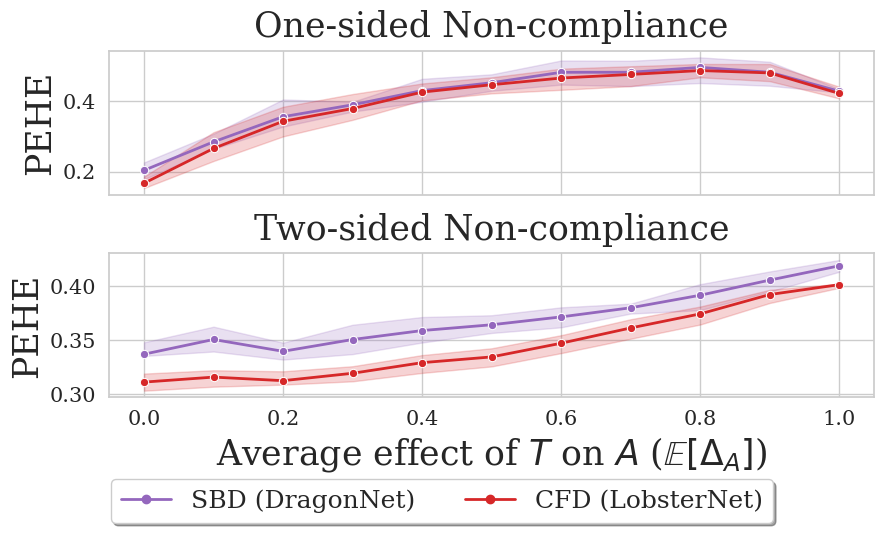

In [29]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
palette = sns.color_palette(['tab:purple', 'tab:red'])
fig, axes = plt.subplots(2, 1, figsize=(10*0.9, 5), sharex="col")
plot_one_sided_amruti_eval_df = one_sided_amruti_eval_df[one_sided_amruti_eval_df.model.isin(["SBD (DragonNet)", "CFD (LobsterNet)"])].copy()
plot_one_sided_amruti_eval_df.nc_rate = (plot_one_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_one_sided_amruti_eval_df["delta_A"] = plot_one_sided_amruti_eval_df.delta_A.round(decimals=1)
plot_two_sided_amruti_eval_df = two_sided_amruti_eval_df[two_sided_amruti_eval_df.model.isin(["SBD (DragonNet)", "CFD (LobsterNet)"])].copy()
plot_two_sided_amruti_eval_df.nc_rate = (plot_two_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_two_sided_amruti_eval_df["delta_A"] = plot_two_sided_amruti_eval_df.delta_A.round(decimals=1)
sns.lineplot(data=plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_one_sided_amruti_eval_df.prescription=="NIT")], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[0], markers=["o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
sns.lineplot(data=plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_two_sided_amruti_eval_df.type==0)], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[1], markers=["o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
axes[0].set_ylabel("PEHE", fontsize=25)
axes[1].set_ylabel("PEHE", fontsize=25)
axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Average effect of $T$ on $A$ ($\mathbb{E}[\Delta_A]$)", fontsize=25)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=18,
           fancybox=True, shadow=True)
fig.tight_layout()
fig.savefig("outputs/amruti_dragon_vs_lobster.pdf", bbox_inches='tight')

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h


print('one-sided')
for method in one_sided_amruti_eval_df.model.unique():
    print(f"\t{method}: ", end="")
    mean, ci_pm = mean_confidence_interval(
        one_sided_amruti_eval_df[(one_sided_amruti_eval_df.model==method) & (one_sided_amruti_eval_df.label=="assign effect PEHE")].value)
    print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")

print('two-sided')
for method in two_sided_amruti_eval_df.model.unique():
    print(f"\t{method}: ", end="")
    mean, ci_pm = mean_confidence_interval(
        two_sided_amruti_eval_df[(two_sided_amruti_eval_df.model==method) & (two_sided_amruti_eval_df.label=="assign effect PEHE")].value)
    print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")

one-sided
	SBD: 0.476 $\pm$ 0.013
	CFD + T-learner: 0.441 $\pm$ 0.019
	CFD + TARNet: 0.420 $\pm$ 0.017
	CFD + DragonNet: 0.419 $\pm$ 0.016
	LobsterNet: 0.400 $\pm$ 0.015
two-sided
	SBD: 0.397 $\pm$ 0.004
	CFD + T-learner: 0.357 $\pm$ 0.005
	CFD + TARNet: 0.353 $\pm$ 0.005
	CFD + DragonNet: 0.353 $\pm$ 0.005
	LobsterNet: 0.342 $\pm$ 0.004


In [7]:
def get_mean_ci_str(x):
    mean, ci_pm = mean_confidence_interval(x)
    return f"{mean:.3f} \u00B1 {ci_pm:.3f}"

one_sided_pehe_df = one_sided_amruti_eval_df[
    (one_sided_amruti_eval_df.label=="assign effect PEHE") & 
    (one_sided_amruti_eval_df.nc_rate.isin([0.1, 0.3, 0.5, 0.7, 0.9]))].groupby(
    ["model", "nc_rate"])["value"].agg(get_mean_ci_str).reset_index().pivot(index="model", columns="nc_rate", values="value")
one_sided_pehe_df.index.name = None
one_sided_pehe_df.columns.name = None
one_sided_pehe_df.columns = one_sided_pehe_df.columns.map(lambda x: f"NC Rate={x}")
one_sided_pehe_df = one_sided_pehe_df.iloc[[-1, 1, 2, 0, 3]]
print(one_sided_pehe_df.style.to_latex())

\begin{tabular}{llllll}
 & NC Rate=0.1 & NC Rate=0.3 & NC Rate=0.5 & NC Rate=0.7 & NC Rate=0.9 \\
SBD & 0.568 ± 0.018 & 0.540 ± 0.017 & 0.494 ± 0.023 & 0.433 ± 0.025 & 0.327 ± 0.021 \\
CFD + T-learner & 0.582 ± 0.009 & 0.529 ± 0.026 & 0.462 ± 0.040 & 0.370 ± 0.040 & 0.241 ± 0.035 \\
CFD + TARNet & 0.534 ± 0.010 & 0.499 ± 0.020 & 0.443 ± 0.037 & 0.366 ± 0.038 & 0.233 ± 0.034 \\
CFD + DragonNet & 0.517 ± 0.015 & 0.495 ± 0.024 & 0.444 ± 0.038 & 0.370 ± 0.040 & 0.240 ± 0.033 \\
LobsterNet & 0.480 ± 0.016 & 0.463 ± 0.021 & 0.423 ± 0.034 & 0.361 ± 0.038 & 0.241 ± 0.034 \\
\end{tabular}



In [8]:
two_sided_pehe_df = two_sided_amruti_eval_df[
    (two_sided_amruti_eval_df.label=="assign effect PEHE") & 
    (two_sided_amruti_eval_df.nc_rate.isin([0.1, 0.3, 0.5, 0.7, 0.9]))].groupby(
    ["model", "nc_rate"])["value"].agg(get_mean_ci_str).reset_index().pivot(index="model", columns="nc_rate", values="value")
two_sided_pehe_df.index.name = None
two_sided_pehe_df.columns.name = None
two_sided_pehe_df.columns = two_sided_pehe_df.columns.map(lambda x: f"NC Rate={x}")
two_sided_pehe_df = two_sided_pehe_df.iloc[[-1, 1, 2, 0, 3]]
print(two_sided_pehe_df.style.to_latex())
two_sided_pehe_df

\begin{tabular}{llllll}
 & NC Rate=0.1 & NC Rate=0.3 & NC Rate=0.5 & NC Rate=0.7 & NC Rate=0.9 \\
SBD & 0.410 ± 0.008 & 0.391 ± 0.011 & 0.377 ± 0.010 & 0.395 ± 0.010 & 0.426 ± 0.006 \\
CFD + T-learner & 0.383 ± 0.005 & 0.334 ± 0.007 & 0.325 ± 0.008 & 0.357 ± 0.011 & 0.412 ± 0.007 \\
CFD + TARNet & 0.381 ± 0.005 & 0.333 ± 0.007 & 0.322 ± 0.008 & 0.353 ± 0.010 & 0.406 ± 0.007 \\
CFD + DragonNet & 0.388 ± 0.008 & 0.332 ± 0.007 & 0.320 ± 0.006 & 0.351 ± 0.011 & 0.404 ± 0.007 \\
LobsterNet & 0.369 ± 0.006 & 0.323 ± 0.006 & 0.314 ± 0.006 & 0.342 ± 0.008 & 0.388 ± 0.005 \\
\end{tabular}



,NC Rate=0.1,NC Rate=0.3,NC Rate=0.5,NC Rate=0.7,NC Rate=0.9
SBD,0.410 ± 0.008,0.391 ± 0.011,0.377 ± 0.010,0.395 ± 0.010,0.426 ± 0.006
CFD + T-learner,0.383 ± 0.005,0.334 ± 0.007,0.325 ± 0.008,0.357 ± 0.011,0.412 ± 0.007
CFD + TARNet,0.381 ± 0.005,0.333 ± 0.007,0.322 ± 0.008,0.353 ± 0.010,0.406 ± 0.007
CFD + DragonNet,0.388 ± 0.008,0.332 ± 0.007,0.320 ± 0.006,0.351 ± 0.011,0.404 ± 0.007
LobsterNet,0.369 ± 0.006,0.323 ± 0.006,0.314 ± 0.006,0.342 ± 0.008,0.388 ± 0.005


In [9]:
# load one-sided AMR-UTI eval results
num_reps=20
nc_type="one-sided"
model_strs = ["sbd-tlearner", "cfd-tlearner", "hybrid-tlearner"]
nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
eval_df_list = []
for nc_rate in nc_rates: 
    for prescriptions in [["NIT"]]:
        ihdp_setting = f"type={nc_type}/rate={nc_rate}/prescriptions={prescriptions}"
        for model in model_strs:
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"AMR-UTI/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir), ihdp_mod_checkpoint_dir
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["setting"] = ihdp_setting
            ihdp_mod_eval_df["model"] = model
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["prescription"] = prescriptions[0]
            eval_df_list.append(ihdp_mod_eval_df)
one_sided_hybrid_amruti_eval_df = pd.concat(eval_df_list)
one_sided_hybrid_amruti_eval_df.model = one_sided_hybrid_amruti_eval_df.model.map({
    "sbd-tlearner": "SBD", "hybrid-tlearner": "Naive Baseline", "cfd-tlearner": "CFD"
})

100%|██████████| 20/20 [00:00<00:00, 1258.32it/s]


In [10]:
# load two-sided AMR-UTI eval results
num_reps=20
nc_type="two-sided"
model_strs = ["sbd-tlearner", "cfd-tlearner", "hybrid-tlearner"]
nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
eval_df_list = []
for nc_rate in nc_rates: 
    for idx, prescriptions in enumerate([["NIT", "CIP"]]):
        ihdp_setting = f"type={nc_type}/rate={nc_rate}/prescriptions={prescriptions}"
        for model in model_strs:
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"AMR-UTI/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir)
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["setting"] = ihdp_setting
            ihdp_mod_eval_df["model"] = model
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["type"] = idx
            eval_df_list.append(ihdp_mod_eval_df)
two_sided_hybrid_amruti_eval_df = pd.concat(eval_df_list)
two_sided_hybrid_amruti_eval_df.model = two_sided_hybrid_amruti_eval_df.model.map({
    "sbd-tlearner": "SBD", "hybrid-tlearner": "Naive Baseline", "cfd-tlearner": "CFD"
})

100%|██████████| 20/20 [00:00<00:00, 1244.34it/s]


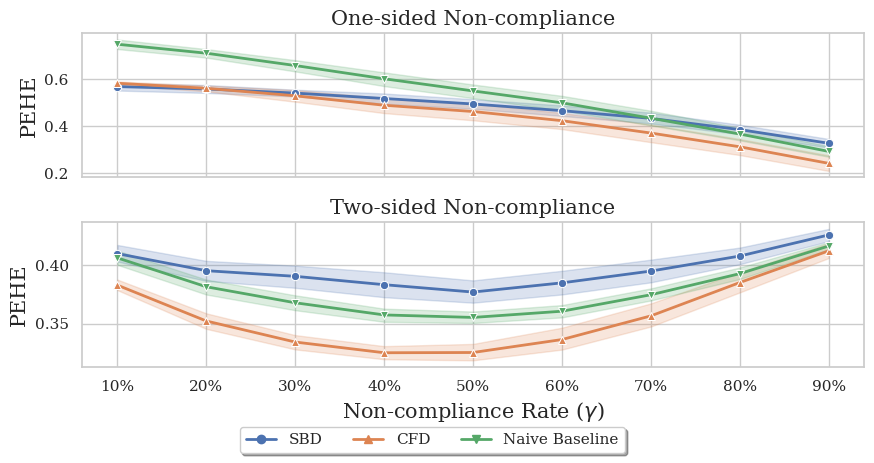

In [11]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
fig, axes = plt.subplots(2, 1, figsize=(10*0.9, 5*0.9), sharex="col")
plot_one_sided_amruti_eval_df = one_sided_hybrid_amruti_eval_df.copy()
plot_one_sided_amruti_eval_df.nc_rate = (plot_one_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_two_sided_amruti_eval_df = two_sided_hybrid_amruti_eval_df.copy()
plot_two_sided_amruti_eval_df.nc_rate = (plot_two_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
sns.lineplot(data=plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_one_sided_amruti_eval_df.prescription=="NIT")], 
             x="nc_rate", y="value", hue="model", style="model", ax=axes[0], markers=["o", "^", "v"], errorbar=("ci", 95), dashes=False)
sns.lineplot(data=plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_two_sided_amruti_eval_df.type==0)], 
             x="nc_rate", y="value", hue="model", style="model", ax=axes[1], markers=["o", "^", "v"], errorbar=("ci", 95), dashes=False)
axes[0].set_ylabel("PEHE", fontsize=15)
axes[1].set_ylabel("PEHE", fontsize=15)
axes[0].set_title(r"One-sided Non-compliance", fontsize=15)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=11)
axes[1].tick_params(axis='both', which='major', labelsize=11)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Non-compliance Rate ($\gamma$)", fontsize=15)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5, fancybox=True, shadow=True)
fig.tight_layout()
fig.savefig("outputs/amruti_naive_baseline.pdf", bbox_inches='tight')

In [24]:
one_sided_pehe_df = one_sided_hybrid_amruti_eval_df[
    (one_sided_hybrid_amruti_eval_df.label=="assign effect PEHE") & 
    (one_sided_hybrid_amruti_eval_df.nc_rate.isin([0.1, 0.3, 0.5, 0.7, 0.9]))].groupby(
    ["model", "nc_rate"])["value"].agg(get_mean_ci_str).reset_index().pivot(index="model", columns="nc_rate", values="value")
one_sided_pehe_df.index.name = None
one_sided_pehe_df.columns.name = None
one_sided_pehe_df.columns = one_sided_pehe_df.columns.map(lambda x: f"NC Rate={x}")
one_sided_pehe_df = one_sided_pehe_df.iloc[[-1, 1, 0]]
print(one_sided_pehe_df.style.to_latex())
one_sided_pehe_df

\begin{tabular}{llllll}
 & NC Rate=0.1 & NC Rate=0.3 & NC Rate=0.5 & NC Rate=0.7 & NC Rate=0.9 \\
SBD & 0.562 ± 0.024 & 0.531 ± 0.022 & 0.486 ± 0.029 & 0.428 ± 0.030 & 0.321 ± 0.022 \\
Naive Baseline & 0.749 ± 0.023 & 0.658 ± 0.025 & 0.550 ± 0.033 & 0.433 ± 0.034 & 0.292 ± 0.024 \\
CFD & 0.581 ± 0.007 & 0.530 ± 0.024 & 0.462 ± 0.040 & 0.370 ± 0.041 & 0.239 ± 0.035 \\
\end{tabular}



,NC Rate=0.1,NC Rate=0.3,NC Rate=0.5,NC Rate=0.7,NC Rate=0.9
SBD,0.562 ± 0.024,0.531 ± 0.022,0.486 ± 0.029,0.428 ± 0.030,0.321 ± 0.022
Naive Baseline,0.749 ± 0.023,0.658 ± 0.025,0.550 ± 0.033,0.433 ± 0.034,0.292 ± 0.024
CFD,0.581 ± 0.007,0.530 ± 0.024,0.462 ± 0.040,0.370 ± 0.041,0.239 ± 0.035


In [25]:
two_sided_pehe_df = two_sided_hybrid_amruti_eval_df[
    (two_sided_hybrid_amruti_eval_df.label=="assign effect PEHE") & 
    (two_sided_hybrid_amruti_eval_df.nc_rate.isin([0.1, 0.3, 0.5, 0.7, 0.9]))].groupby(
    ["model", "nc_rate"])["value"].agg(get_mean_ci_str).reset_index().pivot(index="model", columns="nc_rate", values="value")
two_sided_pehe_df.index.name = None
two_sided_pehe_df.columns.name = None
two_sided_pehe_df.columns = two_sided_pehe_df.columns.map(lambda x: f"NC Rate={x}")
two_sided_pehe_df = two_sided_pehe_df.iloc[[-1, 1, 0]]
print(two_sided_pehe_df.style.to_latex())
two_sided_pehe_df

\begin{tabular}{llllll}
 & NC Rate=0.1 & NC Rate=0.3 & NC Rate=0.5 & NC Rate=0.7 & NC Rate=0.9 \\
SBD & 0.408 ± 0.008 & 0.390 ± 0.012 & 0.377 ± 0.013 & 0.394 ± 0.010 & 0.427 ± 0.007 \\
Naive Baseline & 0.406 ± 0.006 & 0.368 ± 0.007 & 0.355 ± 0.006 & 0.375 ± 0.006 & 0.417 ± 0.003 \\
CFD & 0.386 ± 0.005 & 0.335 ± 0.006 & 0.325 ± 0.007 & 0.356 ± 0.010 & 0.413 ± 0.007 \\
\end{tabular}



,NC Rate=0.1,NC Rate=0.3,NC Rate=0.5,NC Rate=0.7,NC Rate=0.9
SBD,0.408 ± 0.008,0.390 ± 0.012,0.377 ± 0.013,0.394 ± 0.010,0.427 ± 0.007
Naive Baseline,0.406 ± 0.006,0.368 ± 0.007,0.355 ± 0.006,0.375 ± 0.006,0.417 ± 0.003
CFD,0.386 ± 0.005,0.335 ± 0.006,0.325 ± 0.007,0.356 ± 0.010,0.413 ± 0.007
